In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py
from tqdm import tqdm, trange
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from mpl_toolkits.axes_grid.inset_locator import inset_axes

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    from BEMHelper import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal
from glob import glob 
from pprint import pprint
from mpltools import color

%matplotlib inline
# %config InlineBackend.figure_format='retina'

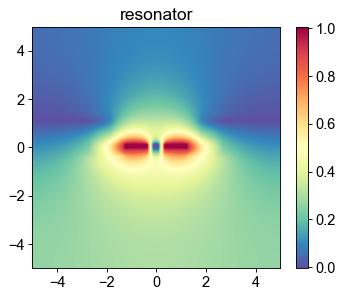

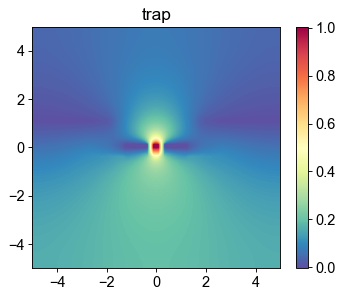

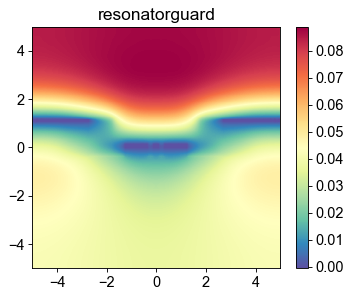

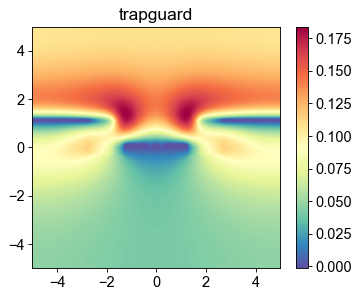

In [2]:
# Evaluate all files in the range
# yeval = anneal.construct_symmetric_y(-5, 201)
# xeval = np.linspace(-5, 8, 301)
xeval = anneal.construct_symmetric_y(-5, 1001)
yeval = np.linspace(-5, 5, 1001)


datafiles = ["Resonator.dsp",
             "Trap.dsp",
             "ResonatorGuard.dsp",
             "TrapGuard.dsp"]
output = list()
names = ['resonator', 'trap', 'resonatorguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(14.,4.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(
        os.path.join('S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6\With L3 etch - just trap\YZ cuts', datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, 
                                                                     nodes, 
                                                                     elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xdata -= xcenter
    ydata -= ycenter

#     plt.figure(figsize=(7.,4.))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, 
                                                                  xeval=xeval, 
                                                                  yeval=yeval, 
                                                                  clim=None, 
                                                                  plot_mesh=False, 
                                                                  plot_data=False,
                                                                  plot_axes='xy', 
                                                                  cmap=plt.cm.viridis)

    # Mirror around the y-axis
    ysize, xsize = np.shape(Uinterp)
    Uinterp_symmetric = np.zeros((ysize, 2 * xsize))
    Uinterp_symmetric[:, :xsize] = Uinterp
    Uinterp_symmetric[:, xsize:] = Uinterp[:, ::-1]

    y_symmetric = np.zeros((ysize, 2 * xsize))
    y_symmetric[:, :xsize] = yinterp
    y_symmetric[:, xsize:] = yinterp

    x_symmetric = np.zeros((ysize, 2 * xsize))
    x_symmetric[:, :xsize] = xinterp
    x_symmetric[:, xsize:] = -xinterp[:, ::-1]
    
    output.append({'name' : name, 
                   'V' : np.array(Uinterp_symmetric, dtype=np.float64),
                   'x' : np.array(x_symmetric, dtype=np.float64), 
                   'y' : np.array(y_symmetric, dtype=np.float64)})
    
for k in range(4):
    plt.figure(figsize=(5.,4.));
    plt.pcolormesh(output[k]['x'], output[k]['y'], output[k]['V'], cmap=plt.cm.Spectral_r)
    plt.title(output[k]["name"])
    plt.xlim(np.min(output[k]['x']), np.max(output[k]['x']))
    plt.ylim(np.min(output[k]['y']), np.max(output[k]['y']))
    plt.colorbar()

(-1, 3)

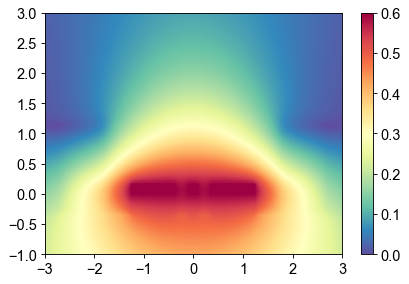

In [37]:
resonator, trap, resonatorguard, trapguard = 0.60, 0.60, -0.50, 0.00

coefficients = np.array([resonator, trap, resonatorguard, trapguard])
    
for k, coeff in enumerate(coefficients):
    if k == 0: 
        combined_potential = coeff * output[k]['V']
    else:
        combined_potential += coeff * output[k]['V']

plt.pcolormesh(output[0]['x'], output[0]['y'], combined_potential, cmap=plt.cm.Spectral_r, vmin=0, vmax=0.60)
plt.colorbar()
plt.xlim(-3, 3)
plt.ylim(-1, 3)

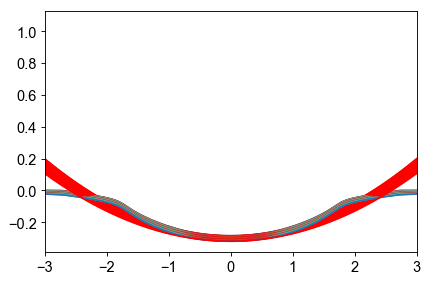

In [35]:
from scipy.constants import m_e, elementary_charge as q_e

zois = np.arange(1.1, 0.95, -0.005)
fe = list()

plt.figure()
common.configure_axes(13)

for zoi in zois:
    zoi_idx = common.find_nearest(output[0]['y'][:, 0], zoi)
    x = output[0]['x'][zoi_idx, :]
    y = -combined_potential[zoi_idx, :]
    plt.plot(x, y)
    
    fr, ferr = kfit.fit_poly(x, y, mode='even', domain=(-0.5, +0.5), fitparams=[0, -1], verbose=False)
    plt.plot(x, kfit.polyfunc_even(x, *fr), color='r')
    plt.xlim(-3, 3)
    
    fe.append(np.sqrt(2 * q_e * fr[1] * 1E12 / m_e) / (2 * np.pi * 1e9))

Fit function: y = a0 + a1*x + a2*x**3 + ...
===========  ==================  ===================
Parameter          Value                 Std
===========  ==================  ===================
a0           12.265466779782287  0.28331833687369645
a1           8.858725887510733   0.2761454190396352
===========  ==================  ===================
Slope is 9 MHz/nm


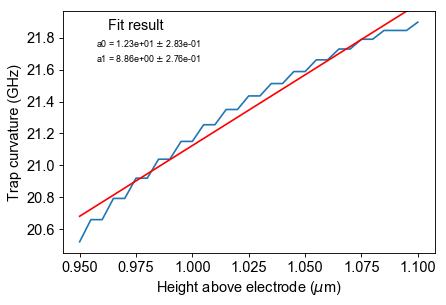

In [36]:
zois = np.array(zois, dtype=np.float64).flatten()
fe = np.array(fe, dtype=np.float64).flatten()

plt.plot(zois, fe)
fr, ferr = kfit.fit_poly(zois, fe, fitparams=[0, 1])#, domain=(0.98, 1.02))
plt.plot(zois, kfit.polyfunc(zois, *fr), '-r')
plt.xlabel("Height above electrode ($\mu$m)")
plt.ylabel("Trap curvature (GHz)")

print("Slope is %.0f MHz/nm"%(fr[1] * 1E3/1E3))